# Mini Project - Quantum Computation
### Adi Tsach | Alan Reuvekamp | Mai Samuel

#### Question 0: We consider the predicate f defined as: $$ f(x_0,x_1,x_2,x_3,x_4) = (\neg x_0 \lor x_1) \land (x_0 \lor x_1 \lor \neg x_2) \land (x_2 \lor x_3) \land (\neg x_1 \lor \neg x_2 \lor x_3) \land (\neg x_3 \lor \neg x_4) \land (\neg x_2 \lor \neg x_3 \lor x_4) $$ Find all possible solutions by exhaustive (or slightly refined ;-) search. How many are there?

In this case we have 5 input qubits, so there are 32 different input options. We calculated the result for each possible input.

In [ ]:
from itertools import product
import pandas as pd

# Define the predicate function based on the logical expression provided
def predicate(x0, x1, x2, x3, x4):
    return (
        ((not x0) or x1) and 
        (x0 or x1 or (not x2)) and 
        (x2 or x3) and
        ((not x1) or (not x2) or x3) and
        ((not x3) or (not x4)) and
        ((not x2) or (not x3) or x4)
    )

# Generate all possible combinations of truth values for x0, x1, x2, x3, x4
combinations = list(product([False, True], repeat=5))

# Compute the predicate value for each combination
results = []
for combination in combinations:
    result = predicate(*combination)
    results.append(combination + (result,))

# Create a DataFrame to hold the results and set appropriate column names
columns = ['x0', 'x1', 'x2', 'x3', 'x4', 'f(x0, x1, x2, x3, x4)']
truth_table = pd.DataFrame(results, columns=columns)

# Filter the DataFrame to show only rows where the predicate is True
valid_solutions = truth_table[truth_table['f(x0, x1, x2, x3, x4)'] == True]

# Display the truth table and the valid solutions
valid_solutions

,x0,x1,x2,x3,x4,"f(x0, x1, x2, x3, x4)"
2,False,False,False,True,False,True
10,False,True,False,True,False,True
26,True,True,False,True,False,True


##### Solutions where $f(x_0, x_1, x_2, x_3, x_4) = 1$

The predicate $f(x_0, x_1, x_2, x_3, x_4)$ evaluates to true for the following three combinations:

1. $x_0 = 0$, $x_1 = 0$, $x_2 = 0$, $x_3 = 1$, $x_4 = 0$

2. $x_0 = 0$, $x_1 = 1$, $x_2 = 0$, $x_3 = 1$, $x_4 = 0$

3. $x_0 = 1$, $x_1 = 1$, $x_2 = 0$, $x_3 = 1$, $x_4 = 0$

These can also be represented in binary form as:
- $(0, 0, 0, 1, 0)$
- $(0, 1, 0, 1, 0)$
- $(1, 1, 0, 1, 0)$

#### Question 1: Design the state preparation circuit
We have five input qubits, six ancilla qubits to store each cluster result and one last qubits to hold the oracle $U_f$ output.

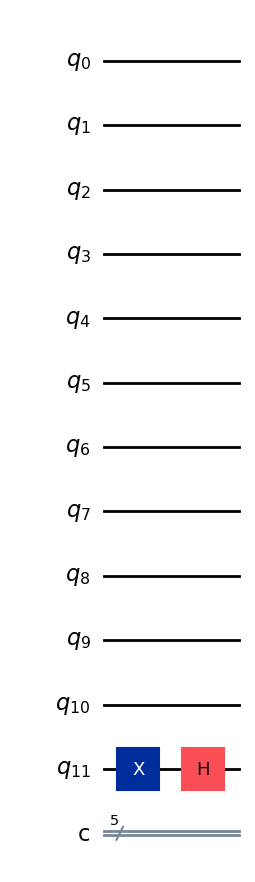

In [ ]:
from qiskit import *
from qiskit_ibm_runtime import *
from qiskit_aer import *


circ_to_draw = QuantumCircuit(12,5)
circ_to_draw.x(11)
circ_to_draw.h(11)

circ_to_draw.draw('mpl')




#### Question 2: Design the oracle gate $U_f$
In order to design the oracle gate $U_f$ we will use ancilla qubit to hold each cluster outcome. To do that we want to use a CCNOT gate, or the generalization of the Toffoli gate.

First, we will use DeMorgan's Law to transform the OR gates inside each cluster into AND gates.

$\neg (A \lor B) = (\neg A) \land (\neg B)$

After implemention of each cluster we get:

$ (\neg x_0 \lor x_1) \rightarrow \neg (x_0 \land \neg x_1)$

$ (x_0 \lor x_1 \lor \neg x_2) \rightarrow \neg ( \neg x_0 \land \neg x_1 \lor x_2)$

$ (x_2 \lor x_3) \rightarrow \neg ( \neg x_2 \land \neg x_3)$

$ (\neg x_1 \lor \neg x_2 \lor x_3) \rightarrow \neg (x_1 \land x_2 \land \neg x_3)$

$ (\neg x_3 \lor \neg x_4) \rightarrow \neg ( x_3 \land x_4)$

$ (\neg x_2 \lor \neg x_3 \lor x_4) \rightarrow \neg (x_2 \land x_3 \land \neg x_4)$

Now we can use CCNOT, 3 controled input CNOT and NOT gates to hold the outcomes in 6 ancilla qubits. Using one more ancilla qubit we can hold the result for the entire $U_f$.

Here we show it with the Hadmard gates too

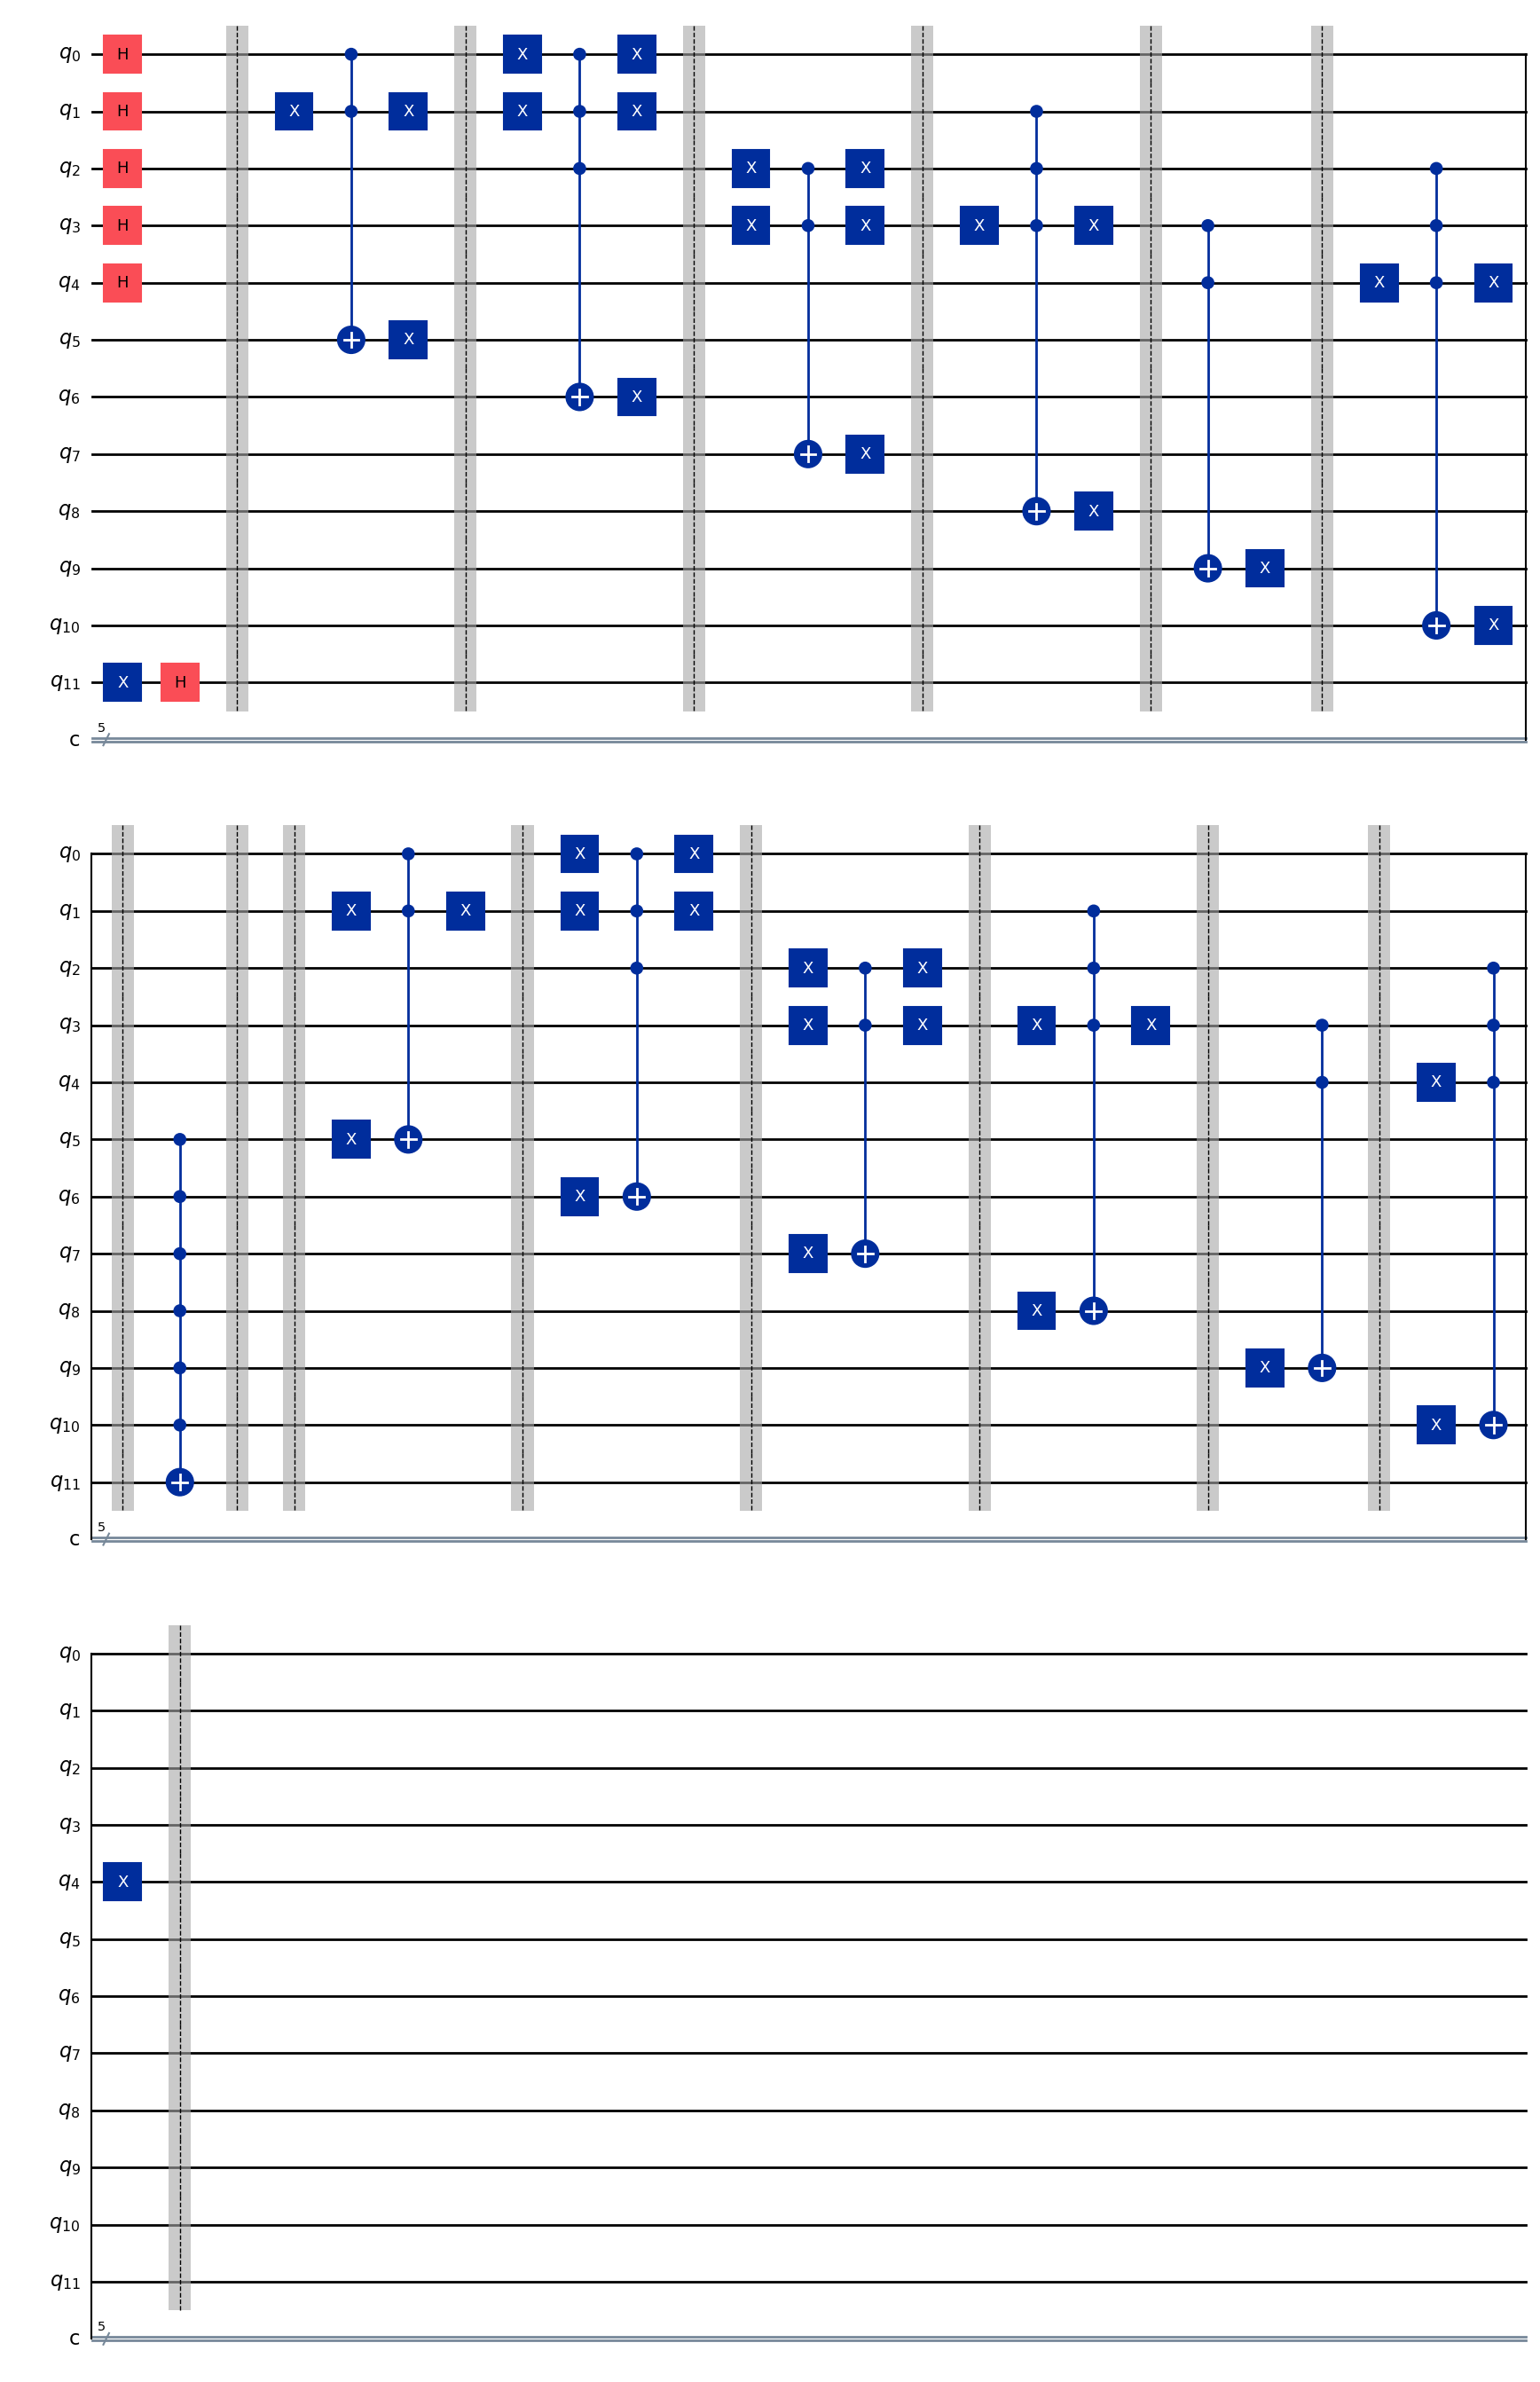

In [ ]:
from qiskit.circuit.library import MCXGate

cccx = MCXGate(3)
ccccx = MCXGate(4)
ccccccx = MCXGate(6)

def U_f(circ_to_oracle):
    circ_to_oracle.h(0)
    circ_to_oracle.h(1)
    circ_to_oracle.h(2)
    circ_to_oracle.h(3)
    circ_to_oracle.h(4)

    
    # First Clause
    
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(1)
    circ_to_oracle.ccx(0,1,5)
    circ_to_oracle.x(5)
    circ_to_oracle.x(1)
    
    # Second Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(0)
    circ_to_oracle.x(1)
    circ_to_oracle.append(cccx, [0, 1, 2, 6])
    circ_to_oracle.x(6)
    circ_to_oracle.x(0)
    circ_to_oracle.x(1)
    
    # Third Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(2)
    circ_to_oracle.x(3)
    circ_to_oracle.ccx(2,3,7)
    circ_to_oracle.x(7)
    circ_to_oracle.x(2)
    circ_to_oracle.x(3)
    
    # Fourth Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(3)
    circ_to_oracle.append(cccx, [1, 2, 3, 8])
    circ_to_oracle.x(8)
    circ_to_oracle.x(3)
    
    # Fifth Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.ccx(3,4,9)
    circ_to_oracle.x(9)
    
    # Sixth Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(4)
    circ_to_oracle.append(cccx, [2, 3, 4, 10])
    circ_to_oracle.x(10)
    circ_to_oracle.x(4)
    
    circ_to_oracle.barrier()
    
    # And All Clauses
    circ_to_oracle.append(ccccccx, [5, 6, 7, 8, 9, 10, 11])
    
    circ_to_oracle.barrier()
    
    # Reset qubits 5, 6, 7, 8, 9, 10, and 11

    # First Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(1)
    circ_to_oracle.x(5)
    circ_to_oracle.ccx(0,1,5)
    circ_to_oracle.x(1)
    
    # Second Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(0)
    circ_to_oracle.x(1)
    circ_to_oracle.x(6)
    circ_to_oracle.append(cccx, [0, 1, 2, 6])
    circ_to_oracle.x(0)
    circ_to_oracle.x(1)
    
    # Third Clause
    circ_to_oracle.barrier()

    circ_to_oracle.x(7)
    circ_to_oracle.x(2)
    circ_to_oracle.x(3)
    circ_to_oracle.ccx(2,3,7)
    circ_to_oracle.x(2)
    circ_to_oracle.x(3)
    
    # Fourth Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(3)
    circ_to_oracle.x(8)
    circ_to_oracle.append(cccx, [1, 2, 3, 8])
    circ_to_oracle.x(3)
    
    # Fifth Clause
    circ_to_oracle.barrier()
        
    circ_to_oracle.x(9)
    circ_to_oracle.ccx(3,4,9)
    
    # Sixth Clause
    circ_to_oracle.barrier()
    
    circ_to_oracle.x(4)
    circ_to_oracle.x(10)
    circ_to_oracle.append(cccx, [2, 3, 4, 10])
    circ_to_oracle.x(4)

    
    circ_to_oracle.barrier()
    return circ_to_oracle
U = U_f(circ_to_draw)
U.draw('mpl')


#### Question 3: Design the reflection operator R (not forgetting the pre and pose Hadamard gates!)

Using the hint, we propose the following gate.
First we will show that $$U =\mathbf{I} - 2 |00000\rangle\langle 00000|$$
Correspond to the inner gate, as demonstrated in Hw.10.

Only for the entries $\left|00000\right>$ and $\left|00001\right>$ the CNOT gate will activate.

The entry $\left|00000\right>$ is mapped to
$$\left|00000\right> \rightarrow \left|11111\right> \rightarrow \frac{1}{\sqrt{2}}(\left|11110\right>-\left|11111\right>) \rightarrow \frac{1}{\sqrt{2}}(\left|11111\right> - \left|11110\right>)
$$

$$\rightarrow \frac{1}{2} (\left|11110\right> - \left|11111\right> - \left|11110\right> -\left|11111\right> = -\left|11111\right> \rightarrow -\left|00000\right>$$

The entry $\left|00001\right>$ is mapped to
$$\left|00001\right> \rightarrow \left|11110\right> \rightarrow \frac{1}{\sqrt{2}}(\left|11110\right>+\left|11111\right>) \rightarrow \frac{1}{\sqrt{2}}(\left|11111\right> + \left|11110\right>)
$$

$$\rightarrow \frac{1}{2} (\left|11110\right> - \left|11111\right> + \left|11110\right> +\left|11111\right> = \left|11110\right> \rightarrow \left|00001\right>$$

For all other entries, the controlled gate does not activate. Therefore, by the unitarity of operators, it is evident that the output will equal the input.

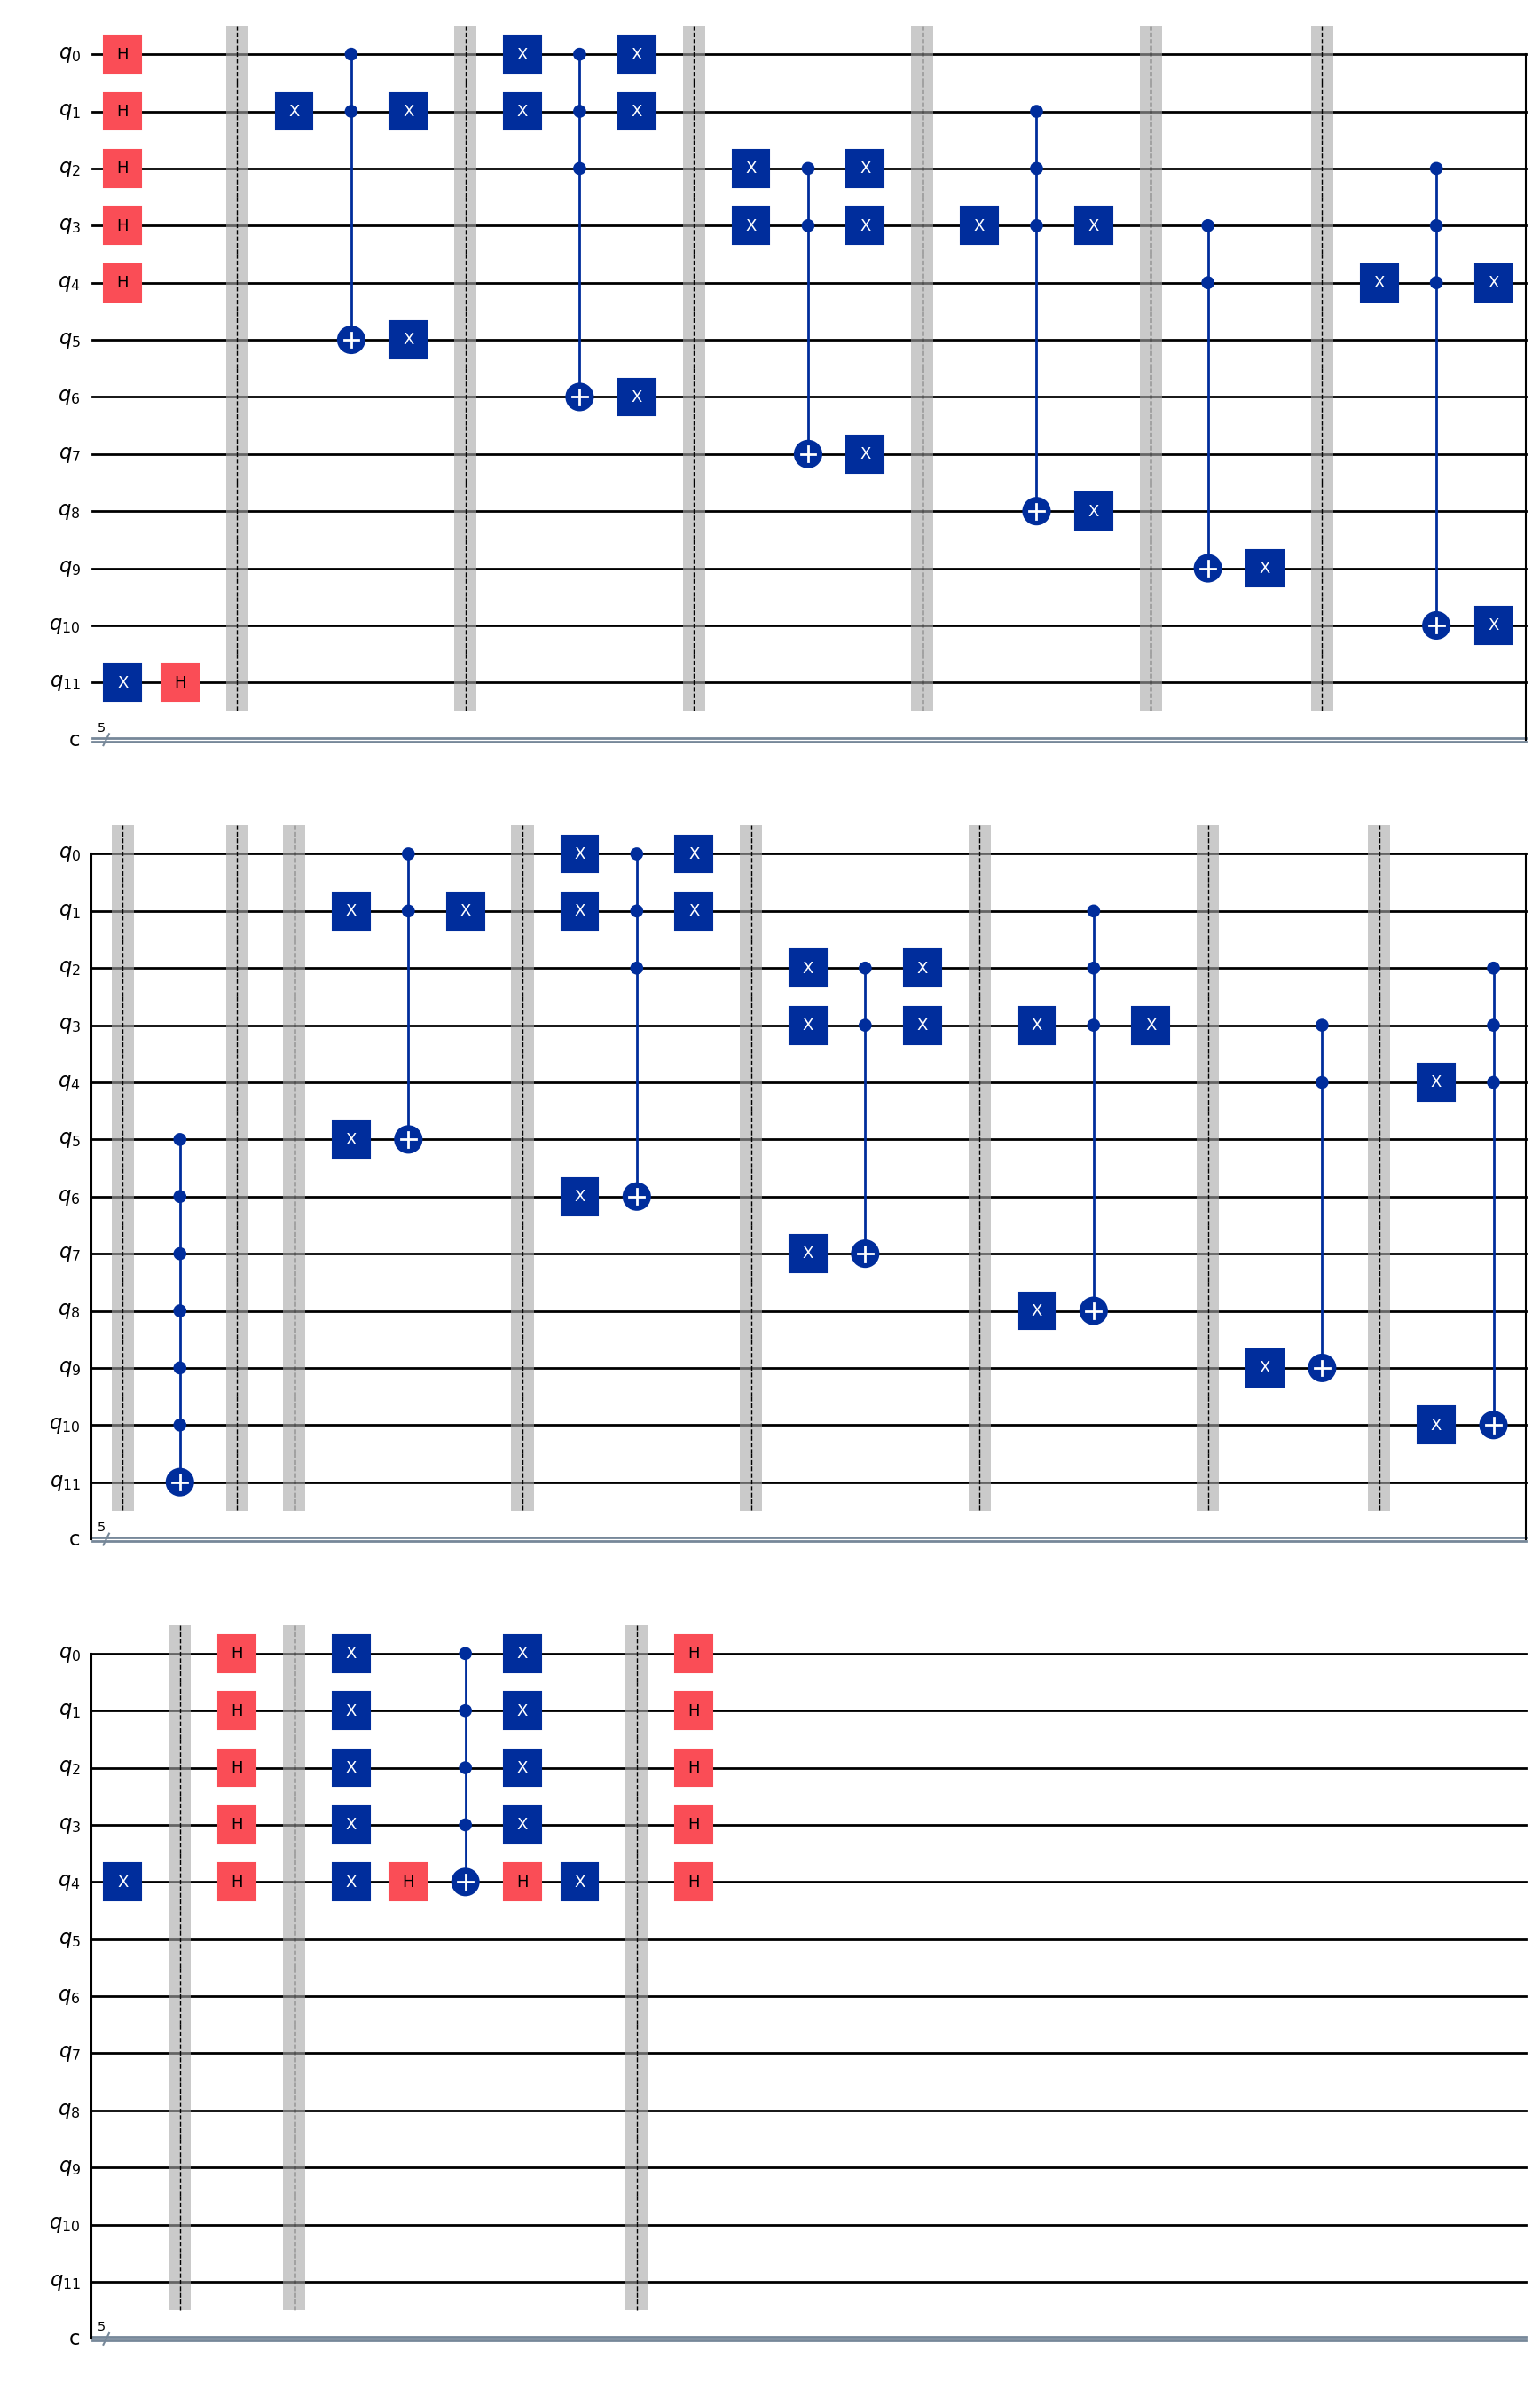

In [ ]:
def R(circ_to_reflect):
    circ_to_reflect.h(0)
    circ_to_reflect.h(1)
    circ_to_reflect.h(2)
    circ_to_reflect.h(3)
    circ_to_reflect.h(4)
    
    circ_to_reflect.barrier()

    circ_to_reflect.x(0)
    circ_to_reflect.x(1)
    circ_to_reflect.x(2)
    circ_to_reflect.x(3)
    circ_to_reflect.x(4)
    
    circ_to_reflect.h(4)
    
    circ_to_reflect.append(ccccx, [0, 1, 2, 3, 4])
    
    circ_to_reflect.h(4)
    
    circ_to_reflect.x(0)
    circ_to_reflect.x(1)
    circ_to_reflect.x(2)
    circ_to_reflect.x(3)
    circ_to_reflect.x(4)
    
    circ_to_reflect.barrier()
    
    circ_to_reflect.h(0)
    circ_to_reflect.h(1)
    circ_to_reflect.h(2)
    circ_to_reflect.h(3)
    circ_to_reflect.h(4)
    return circ_to_reflect
G = R(U)
G.draw('mpl')

#### Question 4: Run your circuit
##### ideal simulator:
##### for $k \in \left\{1, 2, 3, 4\right\} $

In [ ]:
prepared_circuit = QuantumCircuit(12,5)
prepared_circuit.x(11)
prepared_circuit.h(11)

circuits = []

def grover(current_circuit):
    return R(U_f(current_circuit)) 

circ_to_measure = prepared_circuit.copy()

for k in range(4):
    circ_to_measure = grover(circ_to_measure).copy()
    circuits.append(circ_to_measure)
    print(f"The depth of circuit with k = {k+1} iterations is {circ_to_measure.depth()}")


The depth of circuit with k = 1 iterations is 44
The depth of circuit with k = 2 iterations is 87
The depth of circuit with k = 3 iterations is 130
The depth of circuit with k = 4 iterations is 173


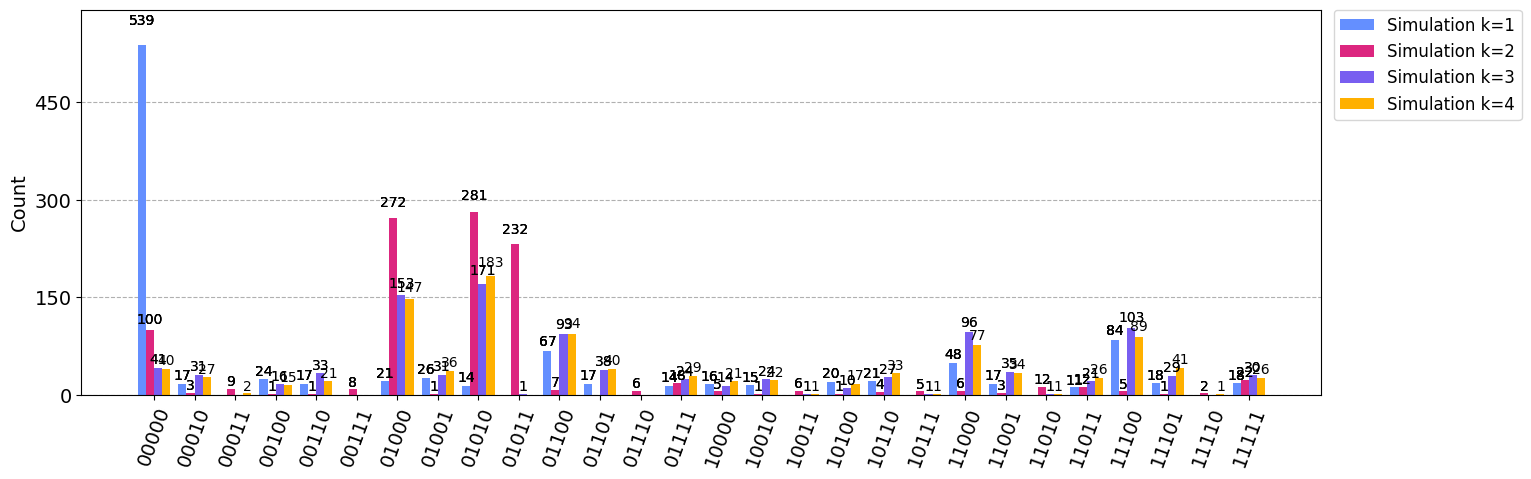

In [ ]:
from qiskit.visualization import plot_histogram

counts_ideal_sim = []

for k in circuits:
    k.measure([0,1,2,3,4], [0,1,2,3,4])

    sim_ideal = AerSimulator()
    result_ideal = sim_ideal.run(k).result()
    counts_ideal_sim.append(result_ideal.get_counts())
plot_histogram([counts_ideal_sim[0], counts_ideal_sim[1], counts_ideal_sim[2], counts_ideal_sim[3]],figsize=(16, 5), legend=['Simulation k=1', 'Simulation k=2', 'Simulation k=3', 'Simulation k=4'])

##### noisy simulator (noise model from a real machine):

In [ ]:

from qiskit_ibm_runtime import QiskitRuntimeService

TOKEN = "280f3f5c636b47fc573705ffdf755dfcea4a1d5e38e7f5ea9bfa1dabf1381ef4fd216e2e1661ac47001e837456f9ce128032d6b22d4b30d4c0953bd66ff75f02"

# One-time access:
#service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

# Save an IBM Quantum account and set it as your default account.
# Please do this only if you trust the device!
QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN, set_as_default=True, overwrite=True)
service = QiskitRuntimeService()

In [ ]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [ ]:
backend_true = service.backend("ibm_osaka")

In [ ]:
backend_true.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

In [ ]:
from qiskit_aer.noise import NoiseModel
noise_model = NoiseModel.from_backend(backend_true)


The depth of circuit is 5135
The depth of circuit is 8102
The depth of circuit is 10293
The depth of circuit is 10338


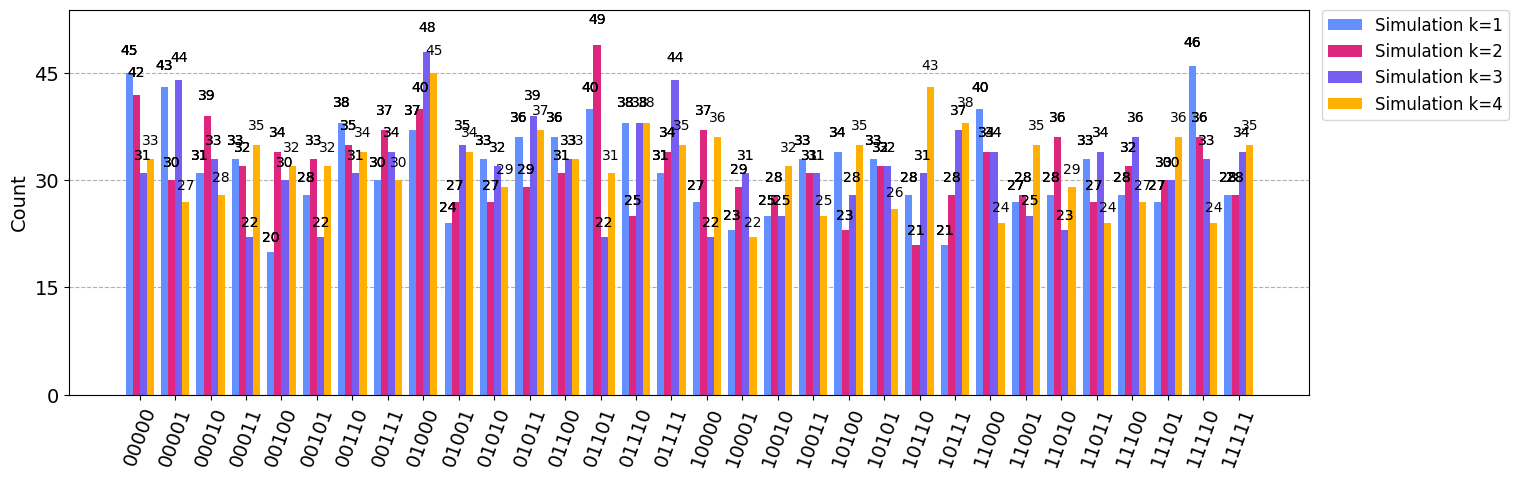

In [ ]:
from qiskit.visualization import plot_histogram

counts_noisy_sim = []

for k in circuits:
    k.measure([0,1,2,3,4], [0,1,2,3,4])
    transpiled_circ = transpile(k, backend_true)
    
    print(f"The depth of circuit is {transpiled_circ.depth()}")

    sim_noise = AerSimulator(noise_model=noise_model)
    result_noisy = sim_noise.run(transpiled_circ).result()
    counts_noisy_sim.append(result_noisy.get_counts())
plot_histogram([counts_noisy_sim[0], counts_noisy_sim[1], counts_noisy_sim[2], counts_noisy_sim[3]],figsize=(16, 5), legend=['Simulation k=1', 'Simulation k=2', 'Simulation k=3', 'Simulation k=4'])

##### REAL MACHINE:

In [ ]:
counts_real = []

for k in circuits:  
    k.measure([0,1,2,3,4], [0,1,2,3,4]) 

    transpiled_circ = transpile(k, backend_true)

    job_real = backend_true.run(transpiled_circ, shots=1024)
    results_real = job_real.result()
    counts_real.append(results_real.get_counts())


/tmp/ipykernel_1429/2370150638.py:8: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job_real = backend_true.run(transpiled_circ, shots=1024)


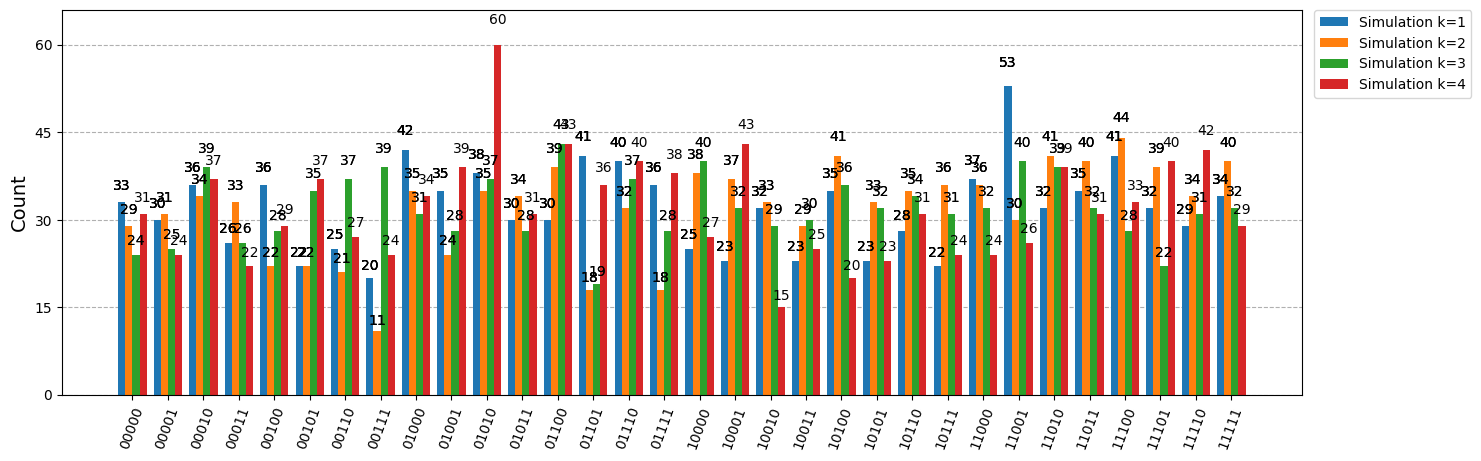

In [ ]:
plot_histogram([counts_real[0], counts_real[1], counts_real[2], counts_real[3]],figsize=(16, 5), legend=['Simulation k=1', 'Simulation k=2', 'Simulation k=3', 'Simulation k=4'])

#### Question: Please comment on the solutions you find and the presence of noise, drawing the appropriate corresponding graphs. 
What part of the noise is due to the algorithm itself and what part is due to the noise in the machine? 
Try both with the simulator and one of the real machines (your choice) and describe what you see.

Answer: As expected, the simulation with no noise seemed to yield the most accurate solutions. We can see that when k = 2 our predicted answers are given with the highest probability, in the following question we calculate that indeed k=2 is the most ideal. Both the noisy simulation and the real machine yielded extremely noisy graphs that didn’t allow to draw any conclusive results. Some of the noise was due to the angle not being ideal, that is noise that’s originating from the algorithm’s inaccuracy itself. Most of the noise that we observed was the noise of the machine. The presence of this much noise is due to the complexity of our transpiled circuit, for all of values of k the depth of the circuit was several thousand gates long, ranging between more than 5,000 to more than 10,000 gates.  

#### Question 5: using the answer to question 0: at what initial angle $θ_0$ does the algorithm start, and how many times should Grover’s operator be applied, ideally?
Considering the predicate f, we have 32 outputs but only 3 of them are true. So based on Grover's algorithm we get:

$\sin(\theta_0) = \sqrt{\frac{M}{N}}$   so  $\theta_0 = \arcsin(\sqrt{\frac{M}{N}})$ with $M = 3$ and $N = 2^5 = 32 $

$\theta_0 \approx 17.829^{\circ}$  or  $0.3111  \mathrm{rad}$

Since $\theta$ is small because $M \ll N$, we can set $(2k + 1)\theta_0 \approx \frac{\pi}{2}$ to get the number of iterations so that we render the state as parallel as possible to $\left|S\right>$.

So the number of iterations is $k = \frac{\pi}{4\theta_0}-\frac{1}{2} \approx 2.024$

So if we set k = 2 iterations we have $(2k + 1)\theta_0 = 1.0098\cdot\frac{\pi}{2} \approx \frac{\pi}{2}$

We will find the solution with probability close to 1.